In [36]:
import sys
sys.path.append('/home/xinyiz/pamrats')

import time
import os

import scanpy 
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim

# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import average_precision_score

import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN,MiniBatchKMeans,AgglomerativeClustering
from sklearn import metrics

import anndata as ad
import gc

import pygeodesic.geodesic as geodesic
import json
import matplotlib.image as mpimg
from skimage import io

In [2]:
seed=3

np.random.seed(seed)
def plotembeddingbyCT(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',img=None):
    celltypes=np.unique(ctlist)
#     print(celltypes)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1
        
    colortest=sns.color_palette("husl", celltypes.size)
#     colortest=sns.color_palette("husl", 9)
#     np.random.shuffle(colortest)
    fig, ax = plt.subplots(dpi=400)
    if not img is None:
        plt.imshow(img)
    for ct in celltypes:
        if ct in excludelist:
            continue
        idx=(ctlist==ct)
        if not img is None:
            ax.scatter(
                embedding[idx, plotdimy],
                embedding[idx, plotdimx],
                color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
    #             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )
        else:
            ax.scatter(
                embedding[idx, plotdimx],
                embedding[idx, plotdimy],
                color=colortest[celltypes_dict[ct]],label=ct,s=1.5,alpha=0.5
    #             color=colortest[int(ct)],label=ct,s=1.5,alpha=0.5
                )

    plt.gca().set_aspect('equal', 'datalim')
    fig.set_figheight(5)
    fig.set_figwidth(5)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])
    # Put a legend below current axis
#     ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#               fancybox=True, shadow=True, ncol=2,prop={'size': 6})
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True,ncol=5, shadow=True,prop={'size': 6})
#     ax.legend(ncol=3)
    plt.title(plotname+' embedding', fontsize=12)
    plt.savefig(os.path.join(savepath,savename+savenameAdd+'.jpg'))
#     plt.show()
    
#     fig.clf()
    plt.close('all')
    
    gc.collect()

In [3]:
np.random.seed(seed)
def plotembeddingbyCT_contrast(ctlist,savename,excludelist,embedding,savepath,plotname,plotdimx=0,plotdimy=1,savenameAdd='',maxplot=None): 
    celltypes=np.unique(ctlist)
    celltypes_dict={}
    idx=0
    for ct in celltypes:
        celltypes_dict[ct]=idx
        idx+=1

    colortest=sns.color_palette("tab10")
    if not os.path.exists(os.path.join(savepath)):
        os.makedirs(savepath)

    for ct in celltypes:
        if maxplot and int(ct)>maxplot:
            continue
        fig, ax = plt.subplots()
        if ct == 'Unassigned':
            continue

        idx=(ctlist!=ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[1],label='others',s=1,alpha=0.5
            )

        idx=(ctlist==ct)
        ax.scatter(
            embedding[idx, plotdimx],
            embedding[idx, plotdimy],
            color=colortest[0],label=ct,s=3,alpha=0.5
            )

        plt.gca().set_aspect('equal', 'datalim')
        fig.set_figheight(10)
        fig.set_figwidth(10)
        ax.legend()
        plt.title(plotname+' embedding', fontsize=24)
        plt.gcf().savefig(os.path.join(savepath,savename+'_'+str(ct)+savenameAdd+'.jpg'))
#         plt.show()
#         nplot+=1
        
    
#         fig.clf()
        plt.close('all')
        gc.collect()

In [4]:
def plotCTcomp(labels,ctlist,savepath,savenamecluster,addname=''):
    res=np.zeros((np.unique(labels).size,np.unique(ctlist).size))
    for li in range(res.shape[0]):
        l=np.unique(labels)[li]
        nl=np.sum(labels==l)
        ctlist_l=ctlist[labels==l]
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            res[li,ci]=np.sum(ctlist_l==c)
#             res[li,ci]=np.sum(ctlist_l==c)/nl
    if not byCT:
        addname+=''
        for li in range(res.shape[0]):
            l=np.unique(labels)[li]
            nl=np.sum(labels==l)
            res[li]=res[li]/nl
    else:
        addname+='_normbyCT'
        for ci in range(res.shape[1]):
            c=np.unique(ctlist)[ci]
            nc=np.sum(ctlist==c)
            res[:,ci]=res[:,ci]/nc
    
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(res,cmap='binary')
    ax.set_yticks(np.arange(np.unique(labels).size))
    ax.set_yticklabels(np.unique(labels))
    ax.set_xticks(np.arange(np.unique(ctlist).size))
    ax.set_xticklabels(np.unique(ctlist))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    fig.tight_layout()
    plt.savefig(os.path.join(savepath,savenamecluster+'_ctComposition'+addname+'.jpg'))
    plt.close()
        

## Plot gene expression clusters

In [5]:
datadir='/mnt/external_ssd/xinyi/staci_validation/10xVisiumADFFPE/'
tissuepospath='VisiumFFPE_Mouse_Brain_Alzheimers_AppNote_aggr_tissue_positions_list.csv'
cluster10xpath='analysis/clustering/graphclust/clusters.csv'
tissuepos=pd.read_csv(os.path.join(datadir,tissuepospath),header=None)
cluster10x=pd.read_csv(os.path.join(datadir,cluster10xpath))

In [6]:
cluster10x['tissueID']=cluster10x['Barcode'].apply(lambda x: x.split('-')[1])

In [7]:
tissuepos.index=tissuepos.iloc[:,0]

In [8]:
scalefactor=0.150015
libraryID=pd.read_csv(os.path.join(datadir,'VisiumFFPE_Mouse_Brain_Alzheimers_AppNote_aggregation.csv'))

In [9]:
for s in np.unique(cluster10x['tissueID']):
    clusterRes=cluster10x['Cluster'][cluster10x['tissueID']==s].to_numpy().astype(int)
    sobj_coord_np=tissuepos.loc[cluster10x['Barcode'][cluster10x['tissueID']==s],4:6].to_numpy()*scalefactor
    
    samplename=libraryID['library_id'][int(s)-1]
    img=mpimg.imread(os.path.join(datadir,'spatial',samplename,'tissue_hires_image.png'))
    plotembeddingbyCT(clusterRes,samplename+'_clustering',[],sobj_coord_np,os.path.join(datadir,'plots'),'location'+' of '+s,img=img)

In [10]:
samplenameList=cluster10x['tissueID'].to_numpy()
for s in np.unique(samplenameList):
    samplenameList[samplenameList==s]=libraryID['library_id'][int(s)-1]
byCT=False
plotCTcomp(cluster10x['Cluster'],samplenameList,os.path.join(datadir,'plots'),'cluster')
byCT=True
plotCTcomp(cluster10x['Cluster'],samplenameList,os.path.join(datadir,'plots'),'cluster')

In [11]:
features=scanpy.read_10x_h5(os.path.join(datadir,'VisiumFFPE_Mouse_Brain_Alzheimers_AppNote_filtered_feature_bc_matrix.h5'))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## plot DE gene expression across STACI clusters

In [61]:
featurenames=features.var.index.to_numpy()[np.array(np.sum(features.X,axis=0)>3).flatten()]

In [26]:
rawcounts=features.X.toarray()[:,np.array(np.sum(features.X,axis=0)>3).flatten()]
#normalize
scalefactor={}
libsizeSum=0
scaledCounts=np.zeros_like(rawcounts)
for s in np.unique(samplenameList):
    print(s)
    scaleddata_train=rawcounts[samplenameList==s]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum+=scalefactorS
    scalefactor[s]=scalefactorS
    gc.collect()
    
sizeFactor=libsizeSum/len(np.unique(samplenameList))
for s in np.unique(samplenameList):
    print(s)
    scaleddata_train=rawcounts[samplenameList==s]
    
    scaleddata_train=np.log2(scaleddata_train*(sizeFactor/scalefactor[s])+1) #changed from 1/2 to 1 to avoid negatives
    scaledCounts[samplenameList==s]=scaleddata_train
    gc.collect()

Transgenic_17p9_rep1
Transgenic_17p9_rep2
Transgenic_2p5_rep1
Transgenic_2p5_rep2
Transgenic_5p7_rep1
Transgenic_5p7_rep2
Wildtype_13p4_rep1
Wildtype_13p4_rep2
Wildtype_2p5_rep1
Wildtype_2p5_rep2
Wildtype_5p7_rep1
Wildtype_5p7_rep2
Transgenic_17p9_rep1
Transgenic_17p9_rep2
Transgenic_2p5_rep1
Transgenic_2p5_rep2
Transgenic_5p7_rep1
Transgenic_5p7_rep2
Wildtype_13p4_rep1
Wildtype_13p4_rep2
Wildtype_2p5_rep1
Wildtype_2p5_rep2
Wildtype_5p7_rep1
Wildtype_5p7_rep2


In [27]:
DEsavedir='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/de'
dename='leiden_nn10mdist025n_pcs40res0.1epoch9990_clusters013'
thresh='fc1.1pvalue0.05'
clusterDE=['0','1','3']

In [86]:
#plot DEG exprs over DAPI
scalefactor=0.150015
samplelist=np.unique(samplenameList)
for s in samplelist:
    print(s)
    sidx=samplenameList==s
    xpos=tissuepos.loc[cluster10x['Barcode'][cluster10x['tissueID']==s],4].to_numpy()*scalefactor
    ypos=tissuepos.loc[cluster10x['Barcode'][cluster10x['tissueID']==s],5].to_numpy()*scalefactor
    
    spath=os.path.join(datadir,'plots',s)
    if not os.path.exists(spath):
        os.mkdir(spath)
    d1=io.imread(os.path.join(datadir,'spatial',s,'tissue_hires_image.png'))
    
    for c in clusterDE:
        degup=pd.read_csv(os.path.join(DEsavedir,dename+'UP_'+c+'_'+thresh+'.csv')).to_numpy()
        degdown=pd.read_csv(os.path.join(DEsavedir,dename+'DOWN_'+c+'_'+thresh+'.csv')).to_numpy()
        if degup.size+degdown.size==0:
            continue
        heatmap=np.zeros((d1.shape[0],d1.shape[1],3))
        heatmap[:,:,0]=(d1[:,:,2]-np.min(d1[:,:,2]))/(np.max(d1[:,:,2])-np.min(d1[:,:,2]))

        degup=degup.flatten()
        degdown=degdown.flatten()
        _,degupidx,_=np.intersect1d(np.char.upper(featurenames.astype(str)),degup,return_indices=True)
        _,degdownidx,_=np.intersect1d(np.char.upper(featurenames.astype(str)),degdown,return_indices=True)
        for i in range(np.sum(sidx)):
            heatmap[int(xpos[i]-5):int(xpos[i]+5),int(ypos[i]-5):int(ypos[i]+5),1]=np.sum(scaledCounts[sidx][i,degupidx])-np.sum(scaledCounts[sidx][i,degdownidx])
        heatmapmin=np.min(heatmap[:,:,1])
        heatmapmax=np.max(heatmap[:,:,1])
        heatmap[:,:,1][heatmap[:,:,1]==0]=heatmapmin-10
        heatmapmin-=10
        heatmap[:,:,1]=(heatmap[:,:,1]-heatmapmin)/(heatmapmax-heatmapmin)
        
        fig = plt.figure(frameon=False)
        fig.set_size_inches(d1.shape[0]/1000,d1.shape[1]/1000)
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        ax.imshow(heatmap,aspect='auto')
        
        plt.savefig(os.path.join(spath,'DEGheatmap_'+c+'.png'),dpi=1000)
        plt.close()




Transgenic_17p9_rep1
Transgenic_17p9_rep2
Transgenic_2p5_rep1
Transgenic_2p5_rep2
Transgenic_5p7_rep1
Transgenic_5p7_rep2
Wildtype_13p4_rep1
Wildtype_13p4_rep2
Wildtype_2p5_rep1
Wildtype_2p5_rep2
Wildtype_5p7_rep1
Wildtype_5p7_rep2


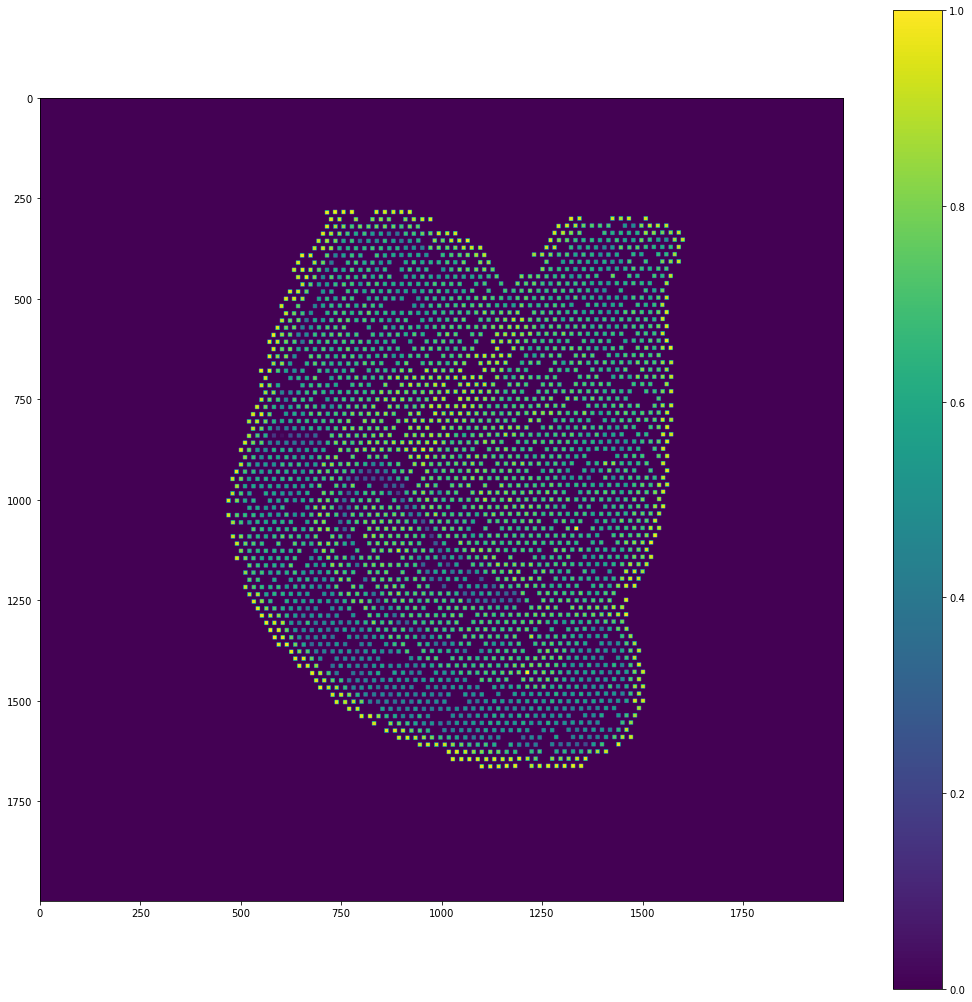

In [83]:
fig, ax = plt.subplots(figsize=(18, 18))
heatmapmin=np.min(heatmap[:,:,1])
heatmapmax=np.max(heatmap[:,:,1])
heatmap[:,:,1][heatmap[:,:,1]==0]=heatmapmin-10
heatmapmin-=10
heatmap[:,:,1]=(heatmap[:,:,1]-heatmapmin)/(heatmapmax-heatmapmin)
plt.imshow(heatmap[:,:,1])
plt.colorbar()

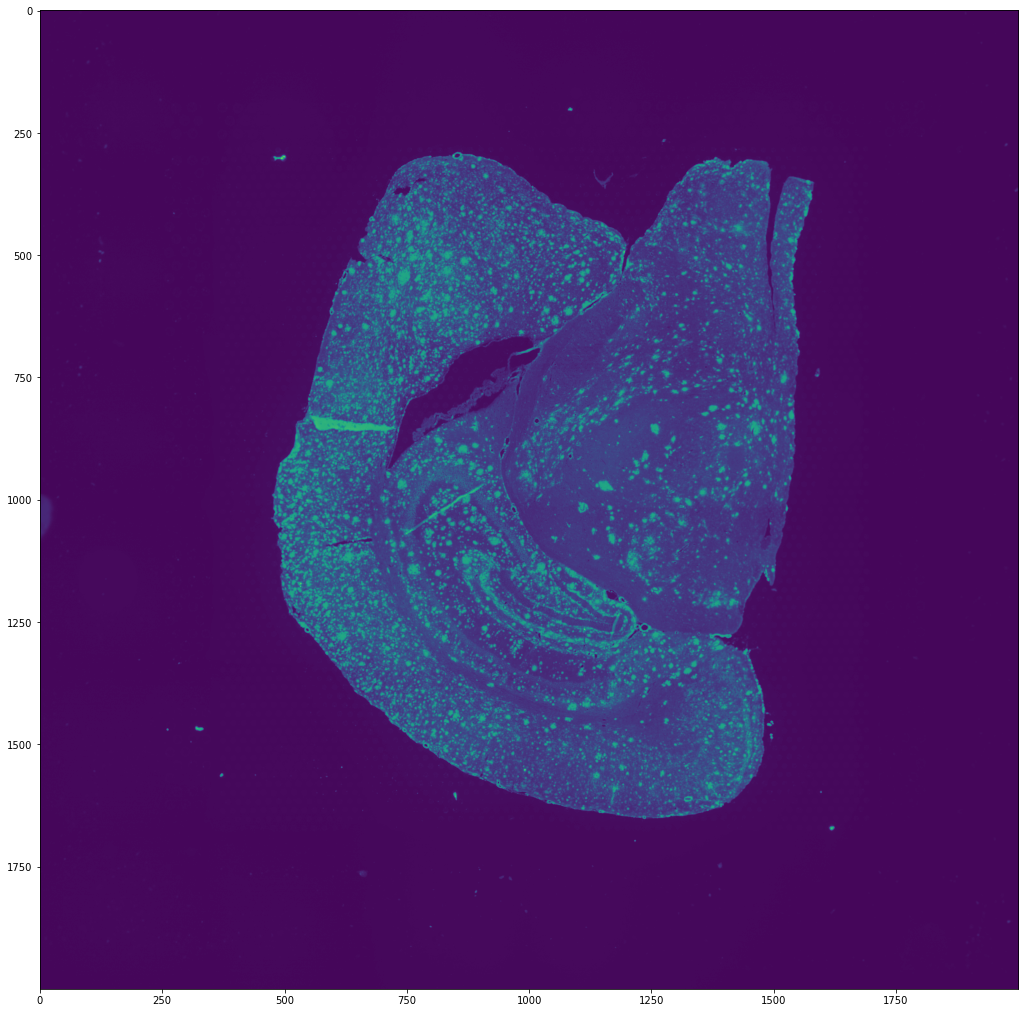

In [54]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.imshow(d1[:,:,0])

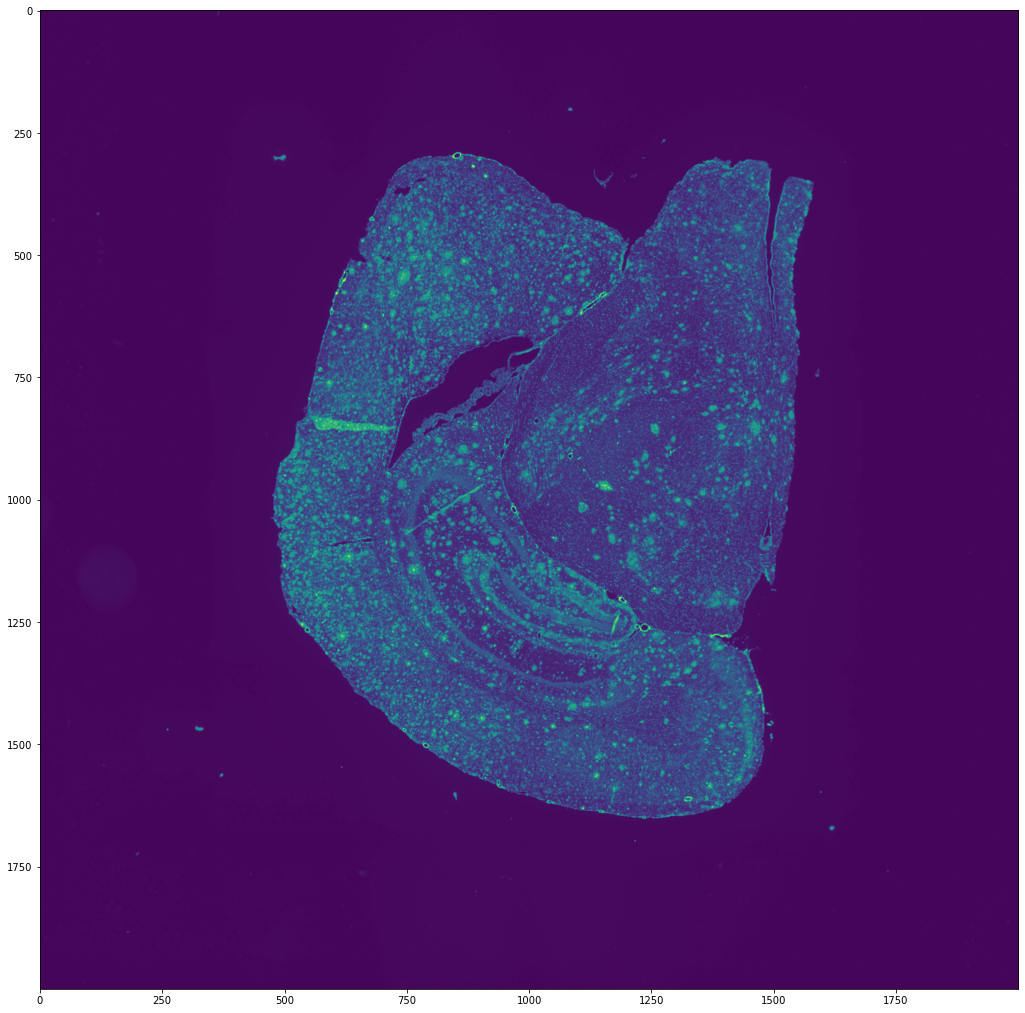

In [51]:
fig, ax = plt.subplots(figsize=(18, 18))

plt.imshow(d1[:,:,1])

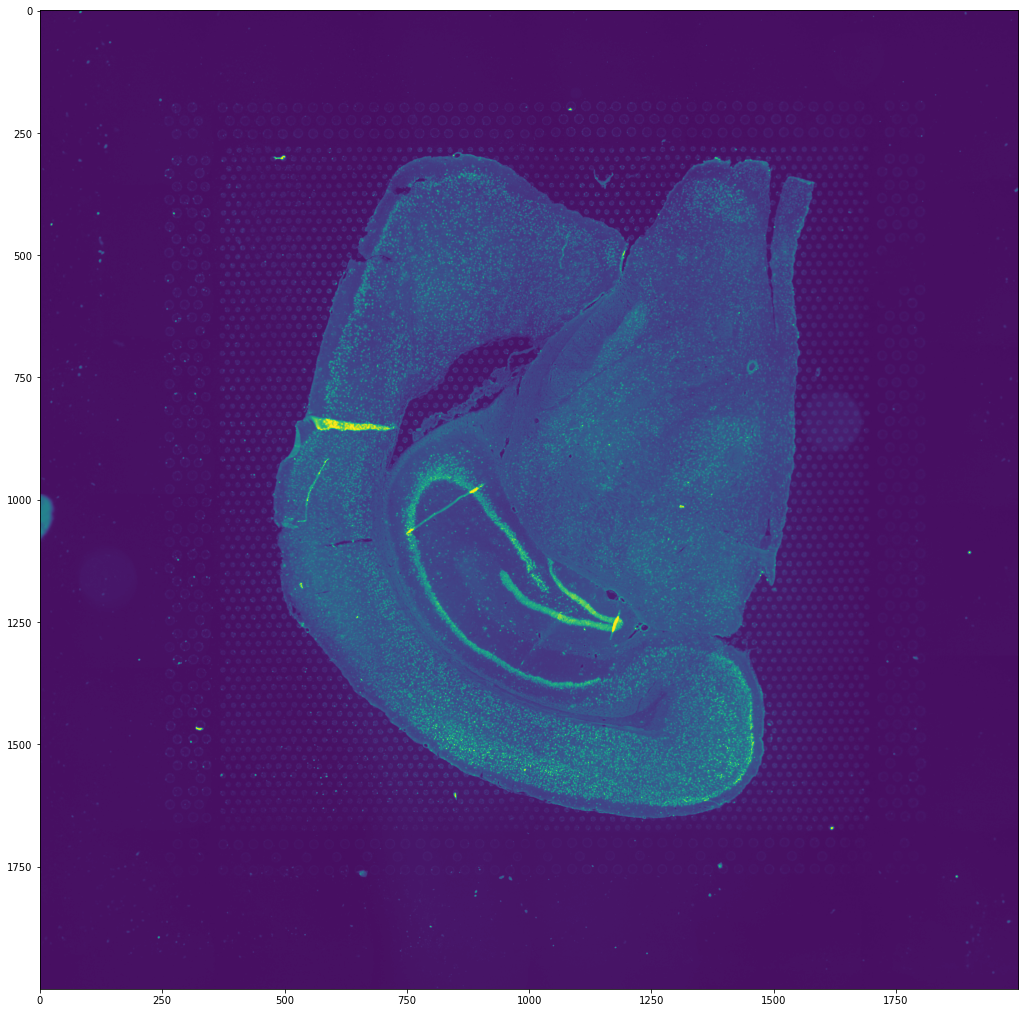

In [52]:
fig, ax = plt.subplots(figsize=(18, 18))


plt.imshow(d1[:,:,2])

## plot STACI clusters

In [2]:
ifplot=True
ifcluster=True

inverseAct='leakyRelu'
# inverseAct=None
plottype='umap'
pca=PCA()
npc=50 #for pca var ration
npc_plot=10 #for pairwise pc plots

minCells=15 #min number of cells for analysis
clustermethod=['leiden']
# clustermethod=['leiden','agglomerative','kmeanbatch']
#umap/leiden clustering parameters
n_neighbors=10
min_dist=0.25
n_pcs=40 #for clustering
resolution=[0.8]
# resolution=[0.025,0.04,0.05,0.1,0.2,0.3,0.5,0.6,0.7,0.8]
plotepoch=3040
savenameAdd=''
#DBscan
epslist= [6,8,10]
min_sampleslist=[15,30,45] 
#agglomerative
nclusterlist=[2,3,4,5,8,10,15]
aggMetric=['euclidean']


combineCelltype={'glia':['Astro','Micro', 'OPC', 'Oligo'],'CA':['CA1', 'CA2', 'CA3']}

use_cuda=True
fastmode=False #Validate during training pass
seed=3
useSavedMaskedEdges=False
maskedgeName='knn6_connectivity'
nneighbors=6
hidden1=30000 #Number of units in hidden layer 1
hidden2=30000 #Number of units in hidden layer 2
# hidden3=16
fc_dim1=30000
# fc_dim2=2112
# fc_dim3=2112
# fc_dim4=2112
# gcn_dim1=2048

protein=None #'scaled_binary'
# proteinWeights=0.05
dropout=0.01
# randFeatureSubset=None
model_str='gcn_vae_xa_e2_d1_dca_sharded'
adj_decodeName=None #gala or None
plot_samples=['V11F08_005_D_WT_dss_d30_colon','V11F08_005_C_WT_GF_colon','V11F08_005_B_WT_SPF_colon','V11F08_005_A_WT_SPF_dss_d73_colon','V10S15_053_B_WT_SPF_dss_d12_colon_pilot','V10S15_053_A_sham_WT_SPF_colon_pilot']
# plot_samples={'control13':'AD_mouse9498','control8':'AD_mouse9735'}
plot_sample_X=['logminmax']
plotRecon='' #'meanRecon'
# plot_sample_X=['corrected','scaled']
standardizeX=False
name='colonk6XA_02_dca_over_strict_myAnno'
logsavepath='/mnt/external_ssd/xinyi/log/train_gae_visium/'+name
modelsavepath='/mnt/external_ssd/xinyi/models/train_gae_visium/'+name
plotsavepath='/mnt/external_ssd/xinyi/plots/train_gae_visium/'+name
datadir='/mnt/external_ssd/xinyi/visium'

In [3]:
def buildMesh_spiral(poslist,savepath):
    poslist=poslist[poslist[:,1]==1]
    if samplename=='V10S15_053_A_sham_WT_SPF_colon_pilot':
        poslist=poslist[:3265]
    if samplename=='V10S15_053_B_WT_SPF_dss_d12_colon_pilot':
        poslist=poslist[1:]
    npoints=poslist.shape[0]
    barcodes=poslist[:,0]
    pidx=np.arange(npoints)
    resPoints=np.zeros((npoints,3))
    resPoints[:,:2]=poslist[:,2:4]
    resCoords=(poslist[:,4:6]*scalefactor).astype(int)    
    resTriang=np.zeros((npoints*2,3))
    currT=0
    for p in range(npoints):
        currP=poslist[p,2:4]
        p0coord=np.ceil(poslist[p,4:6]*scalefactor)
        if currP[0]+1<78 and currP[1]-1>0 and currP[1]+1<128:
            t1p1=[currP[0]+1,currP[1]-1]
            t1p2=[currP[0]+1,currP[1]+1]
            t1p1_idx=pidx[np.sum(poslist[:,2:4]==t1p1,axis=1)==2]
            t1p2_idx=pidx[np.sum(poslist[:,2:4]==t1p2,axis=1)==2]
            if t1p1_idx.size+t1p2_idx.size==2:
                p1coord=np.ceil(poslist[t1p1_idx[0],4:6]*scalefactor)
                p2coord=np.ceil(poslist[t1p2_idx[0],4:6]*scalefactor)
                line1=np.sum(greenpixels[p1coord[0],p1coord[1]:p2coord[1]])
                line2=np.sum(greenpixels[p0coord[0]:p1coord[0],p0coord[1]])
                if line1==0 and line2==0:
                    resTriang[currT]=np.array([p,t1p1_idx[0],t1p2_idx[0]])
                    currT+=1
        if currP[0]+1<78 and currP[1]+2<128:
            t2p1=[currP[0],currP[1]+2]
            t2p2=[currP[0]+1,currP[1]+1]
            t2p1_idx=pidx[np.sum(poslist[:,2:4]==t2p1,axis=1)==2]
            t2p2_idx=pidx[np.sum(poslist[:,2:4]==t2p2,axis=1)==2]
            if t2p1_idx.size+t2p2_idx.size==2:
                p1coord=np.ceil(poslist[t2p1_idx[0],4:6]*scalefactor)
                p2coord=np.ceil(poslist[t2p2_idx[0],4:6]*scalefactor)
                line1=np.sum(greenpixels[p0coord[0],p0coord[1]:p1coord[1]])
                line2=np.sum(greenpixels[p0coord[0]:p2coord[0],p2coord[1]])
                if line1==0 and line2==0:
                    resTriang[currT]=np.array([p,t2p1_idx[0],t2p2_idx[0]])
                    currT+=1
    resTriang=resTriang[:currT]
    ntriang=resTriang.shape[0]
#     minidx=int(np.min(resTriang))
#     maxidx=int(np.max(resTriang))
#     resPoints=resPoints[minidx:(maxidx+1)]
#     resTriang=resTriang-minidx
    res=np.vstack((resPoints,resTriang))
    with open(os.path.join(savepath,'mesh_spiral.txt'),'wb') as output:
        np.savetxt(output,(np.array([npoints,ntriang]).astype(int))[None],delimiter=' ',fmt='%i')
    with open(os.path.join(savepath,'mesh_spiral.txt'),'ab') as output:
        np.savetxt(output,res.astype(int),delimiter=' ',fmt='%i')
    with open(os.path.join(savepath,'barcodeMesh_spiral'), 'wb') as output:
        pickle.dump(barcodes, output, pickle.HIGHEST_PROTOCOL)
    return resPoints.astype(int),resTriang.astype(int),barcodes,resCoords

datadir='/mnt/external_ssd/xinyi/visium'
if 'strict' in name:
    dotdir=os.path.join(datadir,'strict_manual_spot_selection')
else:
    dotdir=datadir
annodir=os.path.join(dotdir,'spirals')
scalefactor=0.06300403
organ=['colon']
samplelist=['V11F08_005_D_WT_dss_d30_colon','V11F08_005_C_WT_GF_colon','V11F08_005_B_WT_SPF_colon','V11F08_005_A_WT_SPF_dss_d73_colon','V10S15_053_B_WT_SPF_dss_d12_colon_pilot','V10S15_053_A_sham_WT_SPF_colon_pilot']

# for f in os.listdir:
savedirlist={}
featureslist={}
features_raw_list={}
adj_list={}
coord_list={}
commonGenes=[]
    
for samplename in samplelist:
    print(samplename)
    savedir=datadir+'/plots/'+samplename
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    testcoord=pd.read_csv(os.path.join(dotdir,samplename,'spatial/tissue_positions_list.csv'),header=None)
    test=scanpy.read_10x_h5(os.path.join(dotdir,samplename,'filtered_feature_bc_matrix.h5'))
    test.var_names_make_unique()
    
    testimg_anno=mpimg.imread(os.path.join(annodir,samplename+'.tif'))
#     greenpixels=testimg_anno>0
    greenpixels=np.sum(testimg_anno==np.array([0,255,0]),axis=2)==3
    points2,faces2,barcodes2,coord2=buildMesh_spiral(testcoord.to_numpy(),savedir)
    coord_list[samplename]=coord2
    
    geoalg2 = geodesic.PyGeodesicAlgorithmExact(points2,faces2)
    adj_list[samplename]=np.zeros((points2.shape[0],points2.shape[0]))
    for testSpot2idx in range(points2.shape[0]):
#         testSpot2=[6,84,0]
#         testSpot2idx=np.arange(points2.shape[0])[np.sum(points2==testSpot2,axis=1)==3]
        distances2, best_source2 = geoalg2.geodesicDistances(np.array([testSpot2idx]))
        adj_list[samplename][testSpot2idx,np.argsort(distances2)[:np.min((nneighbors,np.sum(distances2 !=np.inf)))]]=1
        adj_list[samplename][np.argsort(distances2)[:np.min((nneighbors,np.sum(distances2 !=np.inf)))],testSpot2idx]=1
    np.fill_diagonal(adj_list[samplename],0)
    test.obs[0]=np.arange(test.obs.shape[0]).astype(int)
    scaleddata_train=np.array(test.X.todense())[test.obs.reindex(barcodes2)[0]]
    commonGenes=np.concatenate((np.arange(scaleddata_train.shape[1])[(np.sum(scaleddata_train,axis=0)>1).flatten()],commonGenes))
    commonGenes=np.unique(commonGenes)
    if plot_sample_X[0]=='logminmax':
        featurelog_train=np.log2(scaleddata_train+1/2)
        scaler = MinMaxScaler()
        featurelog_train_minmax=np.transpose(scaler.fit_transform(np.transpose(featurelog_train)))
        featureslist[samplename+'X_'+plot_sample_X[0]]=torch.tensor(featurelog_train_minmax)
    features_raw_list[samplename+'X_'+'raw']=torch.tensor(scaleddata_train)

for samplename in samplelist:
    featureslist[samplename+'X_'+plot_sample_X[0]]=featureslist[samplename+'X_'+plot_sample_X[0]][:,commonGenes]
    features_raw_list[samplename+'X_'+'raw']=features_raw_list[samplename+'X_'+'raw'][:,commonGenes]
    
num_features=commonGenes.size
adjnormlist={}
pos_weightlist={}
normlist={}
for ai in adj_list.keys():
    adjnormlist[ai]=preprocessing.preprocess_graph(adj_list[ai])
    
    pos_weightlist[ai] = torch.tensor(float(adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) / adj_list[ai].sum()) #using full unmasked adj
    normlist[ai] = adj_list[ai].shape[0] * adj_list[ai].shape[0] / float((adj_list[ai].shape[0] * adj_list[ai].shape[0] - adj_list[ai].sum()) * 2)
    
    adj_label=adj_list[ai] + sp.eye(adj_list[ai].shape[0])
    adj_list[ai]=torch.tensor(adj_label)
    


V11F08_005_D_WT_dss_d30_colon


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


V11F08_005_C_WT_GF_colon


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


V11F08_005_B_WT_SPF_colon


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


V11F08_005_A_WT_SPF_dss_d73_colon


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


V10S15_053_B_WT_SPF_dss_d12_colon_pilot


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


V10S15_053_A_sham_WT_SPF_colon_pilot


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


0
0
0
0
0
0


In [4]:
testimg_anno.shape

(1807, 2000, 3)

In [5]:
# load model
num_nodes,num_features = list(featureslist.values())[0].shape
if model_str=='gcn_vae_xa':
    model  = gae.gae.model.GCNModelVAE_XA(num_features, hidden1, hidden2,fc_dim1,fc_dim2,fc_dim3,fc_dim4, dropout)
elif model_str=='fc1':
    model  = gae.gae.model.FCVAE1(num_features, hidden1,dropout)
elif model_str == 'gcn_vae_xa_e2_d1':
    model  = gae.gae.model.GCNModelVAE_XA_e2_d1(num_features, hidden1,hidden2, dropout)
elif model_str == 'gcn_vae_gcnX_inprA':
    model = gae.gae.model.GCNModelVAE_gcnX_inprA(num_features, hidden1, hidden2,gcn_dim1, dropout)
elif model_str=='fc1_dca':
    model = gae.gae.model.FCVAE1_DCA(num_features, hidden1,fc_dim1, dropout)
elif model_str=='fc1_dca_sharded':
    model = gae.gae.model.FCVAE1_DCA_sharded(num_features, hidden1,fc_dim1, dropout)
elif model_str=='gcn_vae_xa_e2_d1_dca':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA(num_features, hidden1,hidden2,fc_dim1, dropout)
elif model_str=='gcn_vae_xa_e2_d1_dca_sharded':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_sharded(num_features, hidden1,hidden2,fc_dim1, dropout)
elif model_str=='gcn_vae_xa_e2_d1_dcaFork':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAfork(num_features, hidden1,hidden2,fc_dim1, dropout)
elif model_str=='gcn_vae_xa_e2_d1_dcaElemPi':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCAelemPi(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
elif model_str=='gcn_vae_xa_e2_d1_dcaConstantDisp':
    model = gae.gae.model.GCNModelVAE_XA_e2_d1_DCA_constantDisp(num_features, hidden1,hidden2,fc_dim1, dropout,shareGenePi)
else:
    print('model not found')
model.load_state_dict(torch.load(os.path.join(modelsavepath,str(plotepoch)+'.pt')))

<All keys matched successfully>

In [8]:
np.random.seed(seed)
def inverseLeakyRelu(v,slope=0.01):
    vnegidx=(v<0)
    v[vnegidx]=1/slope*v[vnegidx]
    return v

In [9]:
np.random.seed(seed)
def clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,resolution,randseed=seed):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    adata=ad.AnnData(inArray)
    scanpy.tl.pca(adata, svd_solver='arpack')
    scanpy.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs)
    scanpy.tl.umap(adata,min_dist=min_dist,random_state=randseed)
    scanpy.tl.leiden(adata,resolution=resolution,random_state=randseed)
    return adata.obs['leiden'].to_numpy()

def clusterLeiden(inArray,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,randseed=seed):
    for r in resolution:
        clusterRes=clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,r,randseed=seed)
#         print(clusterRes.shape)
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'leiden',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

        plotembeddingbyCT(clusterRes,'leiden_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterLeiden_allsample(embedding,savedir,clustersavedir,inArray,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,samplenameList,randseed=seed):
    for r in resolution:
        clusterRes=clusterLeiden_single(inArray,n_neighbors,n_pcs,min_dist,r,randseed=seed)
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'leiden',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'leiden',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        for s in plot_samples:
            sidx=(samplenameList==s)
            img=mpimg.imread(os.path.join(datadir,s,'spatial','detected_tissue_image.jpg'))
            plotembeddingbyCT(clusterRes[sidx],'leiden_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster,img=img)
            plotembeddingbyCT_contrast(clusterRes[sidx],'leiden_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

         

In [10]:
np.random.seed(seed)
def clusterDBscan_single(inArray,eps,min_samples,n_pcs):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    inArray=pca.fit_transform(inArray)
    labels = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(inArray[:,:n_pcs])
#     db = DBSCAN(eps=eps, min_samples=min_samples).fit(inArray[:,:n_pcs])
#     core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
#     core_samples_mask[db.core_sample_indices_] = True
#     labels = db.labels_
    return labels

def clusterDBscan(inArray,epsL,min_samplesL,n_pcs,sobj_coord_np):
    for eps in epsL:
        for min_samples in min_samplesL:
            clusterRes=clusterDBscan_single(inArray,eps,min_samples,n_pcs)
    #         print(clusterRes.shape)
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'dbscan',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

            plotembeddingbyCT(clusterRes,'dbscan_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterDBscan_allsample(embedding,savedir,clustersavedir,inArray,epsL,min_samplesL,n_pcs,sobj_coord_np,samplenameList):
    for eps in epsL:
        for min_samples in min_samplesL:
            clusterRes=clusterDBscan_single(inArray,eps,min_samples,n_pcs)
            savenamecluster='dbscan_eps'+str(eps)+'msample'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'dbscan',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'dbscan',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

            for s in plot_samples:
                sidx=(samplenameList==s)
                img=mpimg.imread(os.path.join(datadir,s,'spatial','detected_tissue_image.jpg'))
                plotembeddingbyCT(clusterRes[sidx],'dbscan_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster,img=img)
                plotembeddingbyCT_contrast(clusterRes[sidx],'dbscan_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

         

In [11]:
np.random.seed(seed)
def clusterAgg_single(inArray,ncluster,aggmetric,n_pcs):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    inArray=pca.fit_transform(inArray)
    labels = AgglomerativeClustering(n_clusters=ncluster,affinity=aggmetric).fit_predict(inArray[:,:n_pcs])
#     labels = agg.labels_
    return labels

def clusterAgg(inArray,nclusterL,aggmetricL,n_pcs,sobj_coord_np):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            clusterRes=clusterAgg_single(inArray,ncluster,aggmetric,n_pcs)
    #         print(clusterRes.shape)
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'agg',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

            plotembeddingbyCT(clusterRes,'agg_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterAgg_allsample(embedding,savedir,clustersavedir,inArray,nclusterL,aggmetricL,n_pcs,sobj_coord_np,samplenameList):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            clusterRes=clusterAgg_single(inArray,ncluster,aggmetric,n_pcs)
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
                pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
            plotembeddingbyCT(clusterRes,'agg',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
            plotembeddingbyCT_contrast(clusterRes,'agg',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

            for s in plot_samples:
                sidx=(samplenameList==s)
                img=mpimg.imread(os.path.join(datadir,s,'spatial','detected_tissue_image.jpg'))
                plotembeddingbyCT(clusterRes[sidx],'agg_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster,img=img)
                plotembeddingbyCT_contrast(clusterRes[sidx],'agg_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

         

In [12]:
np.random.seed(seed)
def clusterMinibatchKmean_single(inArray,ncluster,n_pcs,batchsize=100):
    n_pcs=np.min([inArray.shape[0]-1,inArray.shape[1]-1,n_pcs])
    batchsize=int(np.min([(inArray.shape[0]-1)/3,(inArray.shape[1]-1)/3,batchsize]))
    inArray=pca.fit_transform(inArray)
    labels = MiniBatchKMeans(n_clusters=ncluster,random_state=seed,batch_size=batchsize).fit_predict(inArray[:,:n_pcs])
    return labels

def clusterMinibatchKmean(inArray,nclusterL,n_pcs,sobj_coord_np):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
#         print(clusterRes.shape)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenamecluster)

        plotembeddingbyCT(clusterRes,'minibatchkmean_location',[],sobj_coord_np,savedir,'location'+' of '+s,savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean_location',[],sobj_coord_np,os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster)

def clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,inArray,nclusterL,n_pcs,sobj_coord_np,samplenameList):
    for ncluster in nclusterL:
        clusterRes=clusterMinibatchKmean_single(inArray,ncluster,n_pcs)
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        with open(os.path.join(clustersavedir,savenamecluster), 'wb') as output:
            pickle.dump(clusterRes, output, pickle.HIGHEST_PROTOCOL)
        plotembeddingbyCT(clusterRes,'minibatchkmean',[],embedding,savedir,plottype+' of all samples',savenameAdd=savenamecluster)
        plotembeddingbyCT_contrast(clusterRes,'minibatchkmean',[],embedding,os.path.join(savedir,'contrast'),plottype+' of all samples',savenameAdd=savenamecluster,maxplot=50)

        for s in plot_samples:
            sidx=(samplenameList==s)
            img=mpimg.imread(os.path.join(datadir,s,'spatial','detected_tissue_image.jpg'))
            plotembeddingbyCT(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],savedir,'location'+' of '+s,savenameAdd=savenamecluster,img=img)
            plotembeddingbyCT_contrast(clusterRes[sidx],'minibatchkmean_location'+s,[],sobj_coord_np[sidx],os.path.join(savedir,'contrast'),'location'+' of '+s,savenameAdd=savenamecluster,maxplot=50)

         

In [13]:
#compute embeddings
mulist={}
for s in plot_samples:
    adj=adj_list[s]
    adj_norm = preprocessing.preprocess_graph(adj)
    adj_decode=None
    if adj_decodeName == 'gala':
        adj_decode=preprocessing.preprocess_graph_sharp(adj)
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        features=featureslist[samplename]
        if standardizeX:
            features=torch.tensor(scale(features,axis=0, with_mean=True, with_std=True, copy=True))
#         if use_cuda:
#             model.cuda()
#             features = features.cuda().float()
#             adj_norm=adj_norm.cuda()
#             if adj_decodeName:
#                 adj_decode=adj_decode.cuda()
        
        model.eval()
        if adj_decodeName==None:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm)
        else:
            adj_recon,mu,logvar,z, features_recon = model(features, adj_norm,adj_decode)
        if inverseAct=='leakyRelu':
            muplot=inverseLeakyRelu(mu.cpu().detach().numpy())
        else:
            muplot=mu.cpu().detach().numpy()
        if plotRecon:
            if plotRecon=='meanRecon':
                mulist[samplename]=features_recon[3].cpu().detach().numpy()
        else:
            mulist[samplename]=muplot
        

0
0
0
0
0
0


In [14]:
#all cells
# ifcluster=False
np.random.seed(seed)
for s in plot_samples:
    print(s)
    
#     celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
#     celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    sobj_coord_np=coord_list[s]
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        muplot=np.copy(mulist[samplename])
        
        if inverseAct:
            samplename+='_beforeAct'
       
        sampledir=os.path.join(plotsavepath,samplename+plotRecon)
        savedir=os.path.join(sampledir,'embedding_'+plottype)
        clustersavedir=os.path.join(plotsavepath,samplename,'cluster')
        if not os.path.exists(sampledir):
            os.mkdir(sampledir)
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        if not os.path.exists(clustersavedir):
            os.mkdir(clustersavedir)
            
        if plottype=='umap':
            reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
            embedding = reducer.fit_transform(muplot)
            savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
        elif plottype=='pca':
            embedding=pca.fit_transform(muplot)
            savenameAdd='_epoch'+str(plotepoch)
        
#         if ifplot:
#             plotembeddingbyCT(celltype_broad,'celltype_broad',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenameAdd)
#             plotembeddingbyCT(celltype_sub,'celltype_sub',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenameAdd)
#             plotembeddingbyCT(region,'region',[],embedding,savedir,plottype+' of '+s,savenameAdd=savenameAdd)

#             plotembeddingbyCT_contrast(celltype_sub,'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s,savenameAdd=savenameAdd)
        
        if embedding.shape[0]<minCells:
            continue
        if ifcluster:
            if 'leiden' in clustermethod:
                clusterLeiden(muplot,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,randseed=seed)
                assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
            if 'dbscan' in clustermethod:
                clusterDBscan(muplot,epslist,min_sampleslist,n_pcs,sobj_coord_np)
                assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
            if 'agglomerative' in clustermethod:
                clusterAgg(muplot,nclusterlist,aggMetric,n_pcs,sobj_coord_np)
                assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
            if 'kmeanbatch' in clustermethod:
                clusterMinibatchKmean(muplot,nclusterlist,n_pcs,sobj_coord_np)
                assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0


V11F08_005_D_WT_dss_d30_colon
V11F08_005_C_WT_GF_colon
V11F08_005_B_WT_SPF_colon


KeyboardInterrupt: 

In [15]:
# testmtx=metrics.pairwise_distances(pca.fit_transform(muplot)[:,:40])
# muplot=np.copy(mulist[s+'X_'+xcorr])
# clusterDBscan(muplot,epslist,min_sampleslist,n_pcs,sobj_coord_np)
# np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))
# plt.hist(testmtx)
# plt.savefig(os.path.join(sampledir,'distancePC40hist.jpg'))


In [14]:
# separate plots by cell type
np.random.seed(seed)
for s in plot_samples:
#     if s in ['disease13','control13','disease8']:
#         continue
    print(s)
    sampleidx=plot_samples[s]
    celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
    celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
    region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
    sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
    
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    for xcorr in plot_sample_X:
        samplename=s+'X_'+xcorr
        muplot=np.copy(mulist[samplename])
        
        if inverseAct:
            samplename+='_beforeAct'
        sampledir=os.path.join(plotsavepath,samplename)
        if not os.path.exists(sampledir):
            os.mkdir(sampledir)
        
        for ct in celltypeplot:
#             if s=='disease8' and ct in ['Astro','CA1','CA2','CA3','DG','Endo','Ex','Inhi']:
#             if s=='control8' and ct in ['Astro']:
#                 continue
            print(ct)
            
            savedir=os.path.join(plotsavepath,samplename,'embedding_'+plottype+'_'+ct)
            clustersavedir=os.path.join(plotsavepath,samplename,'cluster'+'_'+ct)
            if not os.path.exists(savedir):
                os.mkdir(savedir)
            if not os.path.exists(clustersavedir):
                os.mkdir(clustersavedir)
            
            if ct in origCT:
                ct_idx=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']==ct
            else:
                ct_idx=False
                for i in combineCelltype[ct]:
                    ct_idx=np.logical_or(ct_idx,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']==i)
            
            if plottype=='umap':
                reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
                embedding = reducer.fit_transform(muplot[ct_idx])
                savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
            elif plottype=='pca':
                embedding=pca.fit_transform(muplot[ct_idx])
                savenameAdd='_epoch'+str(plotepoch)
                
            if ifplot:
    #             plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+s+' '+reg)
                plotembeddingbyCT(celltype_sub[ct_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+s+' '+ct,savenameAdd=savenameAdd)
                plotembeddingbyCT(region[ct_idx],'region',[],embedding,savedir,plottype+' of '+s+' '+ct,savenameAdd=savenameAdd)

                plotembeddingbyCT_contrast(celltype_sub[ct_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+s+' '+ct,savenameAdd=savenameAdd)
            
            if embedding.shape[0]<minCells:
                continue
            if ifcluster:
                if 'leiden' in clustermethod:
                    clusterLeiden(muplot[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],randseed=seed)
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
                if 'dbscan' in clustermethod:
                    clusterDBscan(muplot[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx])
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
                if 'agglomerative' in clustermethod:
                    clusterAgg(muplot[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx])
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
                if 'kmeanbatch' in clustermethod:
                    clusterMinibatchKmean(muplot[ct_idx],nclusterlist,n_pcs,sobj_coord_np[ct_idx])
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0

control8
CA1
CA2
CA3
DG
Endo
Ex
Inhi
LHb


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


Micro
OPC
Oligo
SMC
glia
CA


In [17]:
# combine all latents to one plot 
np.random.seed(seed)
for xcorr in plot_sample_X:
    latents=None
    celltype_broad=None
    celltype_sub=None
    region=None
    samplenameList=None
    sobj_coord_np=None
    
    for s in plot_samples:
        samplename=s+'X_'+xcorr
        muplot=np.copy(mulist[samplename])
            
        if latents is None:
            latents=muplot
            sobj_coord_np=coord_list[s]
            samplenameList=np.repeat(s,muplot.shape[0])
        else:
            latents=np.vstack((latents,muplot))
            sobj_coord_np=np.concatenate((sobj_coord_np,coord_list[s]),axis=0)
            samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)

#     origCT=np.unique(celltype_broad)
#     celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    sampledir=os.path.join(plotsavepath,'combined'+xcorr)
    if inverseAct:
        sampledir+='_beforeAct'
    savedir=os.path.join(sampledir,'embedding_'+plottype)
    clustersavedir=os.path.join(sampledir,'cluster')
    if not os.path.exists(sampledir):
        os.mkdir(sampledir)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    if not os.path.exists(clustersavedir):
        os.mkdir(clustersavedir)
    
    if plottype=='umap':
        npc_plot=2
        reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
        embedding = reducer.fit_transform(latents)
        savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
    elif plottype=='pca':
        pca.fit(latents)
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
        plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'_epoch'+str(plotepoch)+'.jpg'))
        plt.close()
        fig, ax = plt.subplots(dpi=400)
        fig.set_figheight(2.5)
        fig.set_figwidth(10)
        plt.bar(np.arange(npc),pca.explained_variance_[:npc])
        plt.savefig(os.path.join(savedir,'var_'+str(npc)+'_epoch'+str(plotepoch)+'.jpg'))
        plt.close()
        embedding=pca.transform(latents)
#         embedding=pca.fit_transform(latents)
        savenameAdd='_epoch'+str(plotepoch)
#     if ifplot:
#         for dim1 in range(npc_plot-1):
#             for dim2 in range(dim1+1,npc_plot):
#                 plotembeddingbyCT(samplenameList,'sample',[],embedding,savedir,plottype+'of all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
#         #         plotembeddingbyCT(celltype_broad,'celltype_broad',[],embedding,savedir,plottype+'all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
#         #             plotembeddingbyCT(celltype_sub,'celltype_sub',[],embedding,savedir,plottype+'all samples',savenameAdd=savenameAdd)
#         #         plotembeddingbyCT(region,'region',[],embedding,savedir,plottype+'all samples',plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))

#         #             plotembeddingbyCT_contrast(celltype_sub,'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+'all samples',savenameAdd=savenameAdd)    
    
    if embedding.shape[0]<minCells:
        continue
    if ifcluster:
        if 'leiden' in clustermethod:
            clusterLeiden_allsample(embedding,savedir,clustersavedir,latents,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,samplenameList,randseed=seed)
            assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
        if 'dbscan' in clustermethod:
            clusterDBscan_allsample(embedding,savedir,clustersavedir,latents,epslist,min_sampleslist,n_pcs,sobj_coord_np,samplenameList)
            assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
        if 'agglomerative' in clustermethod:
            clusterAgg_allsample(embedding,savedir,clustersavedir,latents,nclusterlist,aggMetric,n_pcs,sobj_coord_np,samplenameList)
            assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
        if 'kmeanbatch' in clustermethod:
            clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,latents,nclusterlist,n_pcs,sobj_coord_np,samplenameList)
            assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#     #by region
#     for reg in np.unique(region):
#         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg)
#         clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg)
#         if not os.path.exists(savedir):
#             os.mkdir(savedir)
#         if not os.path.exists(clustersavedir):
#             os.mkdir(clustersavedir)

#         reg_idx=region==reg

# #         if plottype=='umap':
# #             reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
# #             embedding = reducer.fit_transform(latents[reg_idx])
# #             savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
# #         elif plottype=='pca':
# #             embedding=pca.fit_transform(latents[reg_idx])
# #             savenameAdd='_epoch'+str(plotepoch)
# #         if ifplot:
# #             plotembeddingbyCT(samplenameList[reg_idx],'sample',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
# #             plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
# #             plotembeddingbyCT(celltype_sub[reg_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
# #     #             plotembeddingbyCT(region,'region',[],embedding[reg_idx],savedir,'UMAP of '+s)

# #             plotembeddingbyCT_contrast(celltype_sub[reg_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
        
# #         if embedding.shape[0]<minCells:
# #             continue
# #         if ifcluster:
# #             if 'leiden' in clustermethod:
# #                 clusterLeiden_allsample(embedding,savedir,clustersavedir,latents[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],samplenameList[reg_idx],randseed=seed)
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
# #             if 'dbscan' in clustermethod:
# #                 clusterDBscan_allsample(embedding,savedir,clustersavedir,latents[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
# #             if 'agglomerative' in clustermethod:
# #                 clusterAgg_allsample(embedding,savedir,clustersavedir,latents[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
# #             if 'kmeanbatch' in clustermethod:
# #                 clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,latents[reg_idx],nclusterlist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#         #by region and celltype
#         for ct in celltypeplot:
# #             if not ((reg=='Cortex' and ct in ['Ex']) or (reg=='Hippocampus' and ct in ['CA1','DG','Micro','CA'])):
#             if not ct =='Ex':
# #             if not (ct in ['Micro'] or (reg=='Hippocampus' and ct in ['CA1'])):
#                 continue
#             print(reg+ct)
#             savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg+ct)
#             clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg+ct)
#             if not os.path.exists(savedir):
#                 os.mkdir(savedir)
#             if not os.path.exists(clustersavedir):
#                 os.mkdir(clustersavedir)

            
#             if ct in origCT:
#                 ct_idx=celltype_broad==ct
#             else:
#                 ct_idx=False
#                 for i in combineCelltype[ct]:
#                     ct_idx=np.logical_or(ct_idx,celltype_broad==i)
#             ct_idx=np.logical_and(reg_idx,ct_idx)      
            
#             if np.sum(ct_idx)<3:
#                 continue
#             if plottype=='umap':
#                 reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
#                 embedding = reducer.fit_transform(latents[ct_idx])
#                 savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
#             elif plottype=='pca':
#                 pca.fit(latents[ct_idx])
#                 fig, ax = plt.subplots(dpi=400)
#                 fig.set_figheight(2.5)
#                 fig.set_figwidth(10)
#                 plt.bar(np.arange(npc),pca.explained_variance_ratio_[:npc])
#                 plt.savefig(os.path.join(savedir,'varRatio_'+str(npc)+'.jpg'))
#                 plt.close()
#                 fig, ax = plt.subplots(dpi=400)
#                 fig.set_figheight(2.5)
#                 fig.set_figwidth(10)
#                 plt.bar(np.arange(npc),pca.explained_variance_[:npc])
#                 plt.savefig(os.path.join(savedir,'var_'+str(npc)+'_epoch'+str(plotepoch)+'.jpg'))
#                 plt.close()
#                 embedding=pca.transform(latents[ct_idx])
# #                 embedding=pca.fit_transform(latents[ct_idx])
#                 savenameAdd='_epoch'+str(plotepoch)
                
#             if ifplot:
#                 for dim1 in range(npc_plot-1):
#                     for dim2 in range(dim1+1,npc_plot):
#                         plotembeddingbyCT(samplenameList[ct_idx],'sample',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct,plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
#                 #         plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg)
#                         plotembeddingbyCT(celltype_sub[ct_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct,plotdimx=dim1,plotdimy=dim2,savenameAdd=savenameAdd+'_pc'+str(dim1)+'pc'+str(dim2))
#             #             plotembeddingbyCT(region[ct_idx],'region',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct)

# #                         plotembeddingbyCT_contrast(celltype_sub[ct_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+reg+' all samples'+' '+ct,savenameAdd=savenameAdd)
        
#             if embedding.shape[0]<minCells:
#                 continue
#             if ifcluster:
#                 if 'leiden' in clustermethod:
#                     clusterLeiden_allsample(embedding,savedir,clustersavedir,latents[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],samplenameList[ct_idx],randseed=seed)
#                     assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#                 if 'dbscan' in clustermethod:
#                     clusterDBscan_allsample(embedding,savedir,clustersavedir,latents[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
#                     assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#                 if 'agglomerative' in clustermethod:
#                     clusterAgg_allsample(embedding,savedir,clustersavedir,latents[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
#                     assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#                 if 'kmeanbatch' in clustermethod:
#                     clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,latents[ct_idx],nclusterlist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
#                     assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
# #     #by celltype
# #     for ct in celltypeplot:
# #         print(ct)
# #         savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+ct)
# #         clustersavedir=os.path.join(sampledir,'cluster'+'_'+ct)
# #         if not os.path.exists(savedir):
# #             os.mkdir(savedir)
# #         if not os.path.exists(clustersavedir):
# #             os.mkdir(clustersavedir)

# #         if ct in origCT:
# #             ct_idx=celltype_broad==ct
# #         else:
# #             ct_idx=False
# #             for i in combineCelltype[ct]:
# #                 ct_idx=np.logical_or(ct_idx,celltype_broad==i)

# #         if plottype=='umap':
# #             reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
# #             embedding = reducer.fit_transform(latents[ct_idx])
# #             savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
# #         elif plottype=='pca':
# #             embedding=pca.fit_transform(latents[ct_idx])
# #             savenameAdd='_epoch'+str(plotepoch)
# #         if ifplot:
# #             plotembeddingbyCT(samplenameList[ct_idx],'sample',[],embedding,savedir,plottype+' of '+'all samples'+' '+ct,savenameAdd=savenameAdd)
# #     #         plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg)
# #             plotembeddingbyCT(celltype_sub[ct_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+'all samples'+' '+ct,savenameAdd=savenameAdd)
# #             plotembeddingbyCT(region[ct_idx],'region',[],embedding,savedir,plottype+' of '+'all samples'+' '+ct,savenameAdd=savenameAdd)

# #             plotembeddingbyCT_contrast(celltype_sub[ct_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+'all samples'+' '+ct,savenameAdd=savenameAdd)
        
# #         if embedding.shape[0]<minCells:
# #             continue
# #         if ifcluster:
# #             if 'leiden' in clustermethod:
# #                 clusterLeiden_allsample(embedding,savedir,clustersavedir,latents[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],samplenameList[ct_idx],randseed=seed)
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
# #             if 'dbscan' in clustermethod:
# #                 clusterDBscan_allsample(embedding,savedir,clustersavedir,latents[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
# #             if 'agglomerative' in clustermethod:
# #                 clusterAgg_allsample(embedding,savedir,clustersavedir,latents[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
# #             if 'kmeanbatch' in clustermethod:
# #                 clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,latents[ct_idx],nclusterlist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
# #                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0

In [ ]:
ifcluster=True
ifplot=True
#for testing: combine latent of some samples
np.random.seed(seed)
plot_samples={'control13':'AD_mouse9498','control8':'AD_mouse9735'}
for xcorr in plot_sample_X:
    latents=None
    celltype_broad=None
    celltype_sub=None
    region=None
    samplenameList=None
    sobj_coord_np=None
    
    for s in plot_samples:
        sampleidx=plot_samples[s]        
        samplename=s+'X_'+xcorr
        muplot=np.copy(mulist[samplename])
            
        if latents is None:
            latents=muplot
            celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']
            celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']
            region=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']
            sobj_coord_np=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()
            samplenameList=np.repeat(s,muplot.shape[0])
        else:
            latents=np.vstack((latents,muplot))
            celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'top_level']),axis=None)
            celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'cell_type_label']),axis=None)
            region=np.concatenate((region,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,'region']),axis=None)
            sobj_coord_np=np.concatenate((sobj_coord_np,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx,['x','y']].to_numpy()),axis=0)
            samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)
       
    origCT=np.unique(celltype_broad)
    celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
    sampledir=os.path.join(plotsavepath,'controls'+xcorr)
    if inverseAct:
        sampledir+='_beforeAct'
    savedir=os.path.join(sampledir,'embedding_'+plottype)
    clustersavedir=os.path.join(sampledir,'cluster')
    if not os.path.exists(sampledir):
        os.mkdir(sampledir)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    if not os.path.exists(clustersavedir):
        os.mkdir(clustersavedir)
    
#     if plottype=='umap':
#         reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
#         embedding = reducer.fit_transform(latents)
#         savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
#     elif plottype=='pca':
#         embedding=pca.fit_transform(latents)
#         savenameAdd='_epoch'+str(plotepoch)
#     if ifplot:
#         plotembeddingbyCT(samplenameList,'sample',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd)
#         plotembeddingbyCT(celltype_broad,'celltype_broad',[],embedding,savedir,plottype+'all samples',savenameAdd=savenameAdd)
#         plotembeddingbyCT(celltype_sub,'celltype_sub',[],embedding,savedir,plottype+'all samples',savenameAdd=savenameAdd)
#         plotembeddingbyCT(region,'region',[],embedding,savedir,plottype+'all samples',savenameAdd=savenameAdd)

#         plotembeddingbyCT_contrast(celltype_sub,'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+'all samples',savenameAdd=savenameAdd)    
    
#     if embedding.shape[0]<minCells:
#         continue
#     if ifcluster:
#         if 'leiden' in clustermethod:
#             clusterLeiden_allsample(latents,n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np,samplenameList,randseed=seed)
#             assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#         if 'dbscan' in clustermethod:
#             clusterDBscan_allsample(latents,epslist,min_sampleslist,n_pcs,sobj_coord_np,samplenameList)
#             assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#         if 'agglomerative' in clustermethod:
#             clusterAgg_allsample(latents,nclusterlist,aggMetric,n_pcs,sobj_coord_np,samplenameList)
#             assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#         if 'kmeanbatch' in clustermethod:
#             clusterMinibatchKmean_allsample(latents,nclusterlist,n_pcs,sobj_coord_np,samplenameList)
#             assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
    #by region
    for reg in np.unique(region):
        savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg)
        clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg)
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        if not os.path.exists(clustersavedir):
            os.mkdir(clustersavedir)

        reg_idx=region==reg

#         if plottype=='umap':
#             reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
#             embedding = reducer.fit_transform(latents[reg_idx])
#             savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
#         elif plottype=='pca':
#             embedding=pca.fit_transform(latents[reg_idx])
#             savenameAdd='_epoch'+str(plotepoch)
#         if ifplot:
#             plotembeddingbyCT(samplenameList[reg_idx],'sample',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
#             plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
#             plotembeddingbyCT(celltype_sub[reg_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
#     #             plotembeddingbyCT(region,'region',[],embedding[reg_idx],savedir,'UMAP of '+s)

#             plotembeddingbyCT_contrast(celltype_sub[reg_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+'all samples'+' '+reg,savenameAdd=savenameAdd)
        
#         if embedding.shape[0]<minCells:
#             continue
#         if ifcluster:
#             if 'leiden' in clustermethod:
#                 clusterLeiden_allsample(latents[reg_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[reg_idx],samplenameList[reg_idx],randseed=seed)
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#             if 'dbscan' in clustermethod:
#                 clusterDBscan_allsample(latents[reg_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#             if 'agglomerative' in clustermethod:
#                 clusterAgg_allsample(latents[reg_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
#             if 'kmeanbatch' in clustermethod:
#                 clusterMinibatchKmean_allsample(latents[reg_idx],nclusterlist,n_pcs,sobj_coord_np[reg_idx],samplenameList[reg_idx])
#                 assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
        #by region and celltype
        for ct in celltypeplot:
#             if not ((reg=='Cortex' and ct in ['Ex']) or (reg=='Hippocampus' and ct in ['CA1','DG','Micro','CA'])):
            if not (reg=='Hippocampus' and ct in ['CA1']):
                continue
            print(reg+ct)
            savedir=os.path.join(sampledir,'embedding_'+plottype+'_'+reg+ct)
            clustersavedir=os.path.join(sampledir,'cluster'+'_'+reg+ct)
            if not os.path.exists(savedir):
                os.mkdir(savedir)
            if not os.path.exists(clustersavedir):
                os.mkdir(clustersavedir)

            
            if ct in origCT:
                ct_idx=celltype_broad==ct
            else:
                ct_idx=False
                for i in combineCelltype[ct]:
                    ct_idx=np.logical_or(ct_idx,celltype_broad==i)
            ct_idx=np.logical_and(reg_idx,ct_idx)      
            
            if np.sum(ct_idx)<3:
                continue
            if plottype=='umap':
                reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
                embedding = reducer.fit_transform(latents[ct_idx])
                savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
            elif plottype=='pca':
                embedding=pca.fit_transform(latents[ct_idx])
                savenameAdd='_epoch'+str(plotepoch)
                
            if ifplot:
                plotembeddingbyCT(samplenameList[ct_idx],'sample',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct,savenameAdd=savenameAdd)
        #         plotembeddingbyCT(celltype_broad[reg_idx],'celltype_broad',[],embedding,savedir,plottype+' of '+'all samples'+' '+reg)
                plotembeddingbyCT(celltype_sub[ct_idx],'celltype_sub',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct,savenameAdd=savenameAdd)
    #             plotembeddingbyCT(region[ct_idx],'region',[],embedding,savedir,plottype+' of '+reg+' all samples'+' '+ct)

                plotembeddingbyCT_contrast(celltype_sub[ct_idx],'celltype_sub',[],embedding,os.path.join(savedir,'contrast'),plottype+' of '+reg+' all samples'+' '+ct,savenameAdd=savenameAdd)
        
            if embedding.shape[0]<minCells:
                continue
            if ifcluster:
                if 'leiden' in clustermethod:
                    clusterLeiden_allsample(latents[ct_idx],n_neighbors,n_pcs,min_dist,resolution,sobj_coord_np[ct_idx],samplenameList[ct_idx],randseed=seed)
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
                if 'dbscan' in clustermethod:
                    clusterDBscan_allsample(latents[ct_idx],epslist,min_sampleslist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
                if 'agglomerative' in clustermethod:
                    clusterAgg_allsample(latents[ct_idx],nclusterlist,aggMetric,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
                if 'kmeanbatch' in clustermethod:
                    clusterMinibatchKmean_allsample(latents[ct_idx],nclusterlist,n_pcs,sobj_coord_np[ct_idx],samplenameList[ct_idx])
                    assert np.sum(muplot-np.copy(mulist[s+'X_'+xcorr]))==0
    

In [15]:
# combine all latents to one plot -- subcluster 
np.random.seed(seed)

ifplot=True
ifcluster=True

#leiden
subResolution=[0.1]

plottype='umap'
pca=PCA()
minCells_sub=10 #min number of cells for analysis
# clustermethod=['leiden','agglomerative','kmeanbatch']
clustermethod=['leiden']
#umap/leiden clustering parameters
n_neighbors_sub=5
min_dist_sub=0.25
n_pcs_sub=10 #for clustering
resolution_sub=[0.025,0.05,0.1,0.15]
# resolution_sub=[0.005,0.0075,0.01,0.015]
#DBscan
epslist_sub= [6,8,10]
min_sampleslist_sub=[15,30,45] 
#agglomerative
nclusterlist_sub=[2,4,8,12]
aggMetric_sub=['euclidean']

xcorr=plot_sample_X[0]
sampledir=os.path.join(plotsavepath,'combined'+xcorr)
if inverseAct:
    sampledir+='_beforeAct'
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')

def subcluster(clustermethod,labels,savepath,addname):
    latents=None
    celltype_broad=None
    celltype_sub=None
    region=None
    samplenameList=None
    sobj_coord_np=None
    for s in plot_samples:
        samplename=s+'X_'+xcorr
        muplot=np.copy(mulist[samplename])

        if latents is None:
            latents=muplot
            sobj_coord_np=coord_list[s]
            samplenameList=np.repeat(s,muplot.shape[0])
        else:
            latents=np.vstack((latents,muplot))
            sobj_coord_np=np.concatenate((sobj_coord_np,coord_list[s]),axis=0)
            samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)

    sampledir=os.path.join(savepath,'combined')
    savedir_all=os.path.join(sampledir,'embedding_'+plottype)
    clustersavedir_all=os.path.join(sampledir,'cluster')
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    if not os.path.exists(sampledir):
        os.mkdir(sampledir)
    if not os.path.exists(savedir_all):
        os.mkdir(savedir_all)
    if not os.path.exists(clustersavedir_all):
        os.mkdir(clustersavedir_all)
    
    for l in np.unique(labels):
        clusteridx=(labels==l)
#         origCT=np.unique(celltype_broad)
#         celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
        savedir=os.path.join(savedir_all,l)
        clustersavedir=os.path.join(clustersavedir_all,l)
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        if not os.path.exists(clustersavedir):
            os.mkdir(clustersavedir)

        if plottype=='umap':
            reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
            embedding = reducer.fit_transform(latents[clusteridx])
            savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
        elif plottype=='pca':
            embedding=pca.fit_transform(latents[clusteridx])
            savenameAdd='_epoch'+str(plotepoch)
        if ifplot:
            plotembeddingbyCT(samplenameList[clusteridx],'sample',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd)

        if embedding.shape[0]<minCells_sub:
            continue
        if ifcluster:
            if clustermethod=='leiden':
                clusterLeiden_allsample(embedding,savedir,clustersavedir,latents[clusteridx],n_neighbors_sub,n_pcs_sub,min_dist_sub,resolution_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx],randseed=seed)
            elif clustermethod=='dbscan':
                clusterDBscan_allsample(embedding,savedir,clustersavedir,latents[clusteridx],epslist_sub,min_sampleslist_sub,n_pcs_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx])
            elif clustermethod=='agglomerative':
                clusterAgg_allsample(embedding,savedir,clustersavedir,latents[clusteridx],nclusterlist_sub,aggMetric_sub,n_pcs_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx])
            elif clustermethod=='kmeanbatch':
                clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,latents[clusteridx],nclusterlist_sub,n_pcs_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx])

def subclusterLeiden(n_neighbors,n_pcs,min_dist,resolution,addname=''):
    for r in resolution:
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        labels=np.array(labels)
        if np.unique(labels).shape[0]==1:
            continue
        
        savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
        subcluster('leiden',labels,savepath,addname)

def subclusterDBscan(epsL,min_samplesL,n_pcs,addname=''):
    for eps in epsL:
        for min_samples in min_samplesL:
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            labels=np.array(labels)
            if np.unique(labels).shape[0]==1:
                continue
            
            savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
            subcluster('dbscan',labels,savepath,addname)

def subclusterAgg(nclusterL,aggmetricL,n_pcs,addname=''):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            labels=np.array(labels)
            if np.unique(labels).shape[0]==1:
                continue
            savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
            subcluster('agglomerative',labels,savepath,addname)
            
def subclusterMinibatchKmean(nclusterL,n_pcs,addname=''):
    for ncluster in nclusterL:
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        labels=np.array(labels)
        if np.unique(labels).shape[0]==1:
            continue
            
        savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
        subcluster('kmeanbatch',labels,savepath,addname)
        
subclusterLeiden(n_neighbors,n_pcs,min_dist,subResolution,addname='')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [17]:
# combine all latents to one plot -- subcluster  skipping pilot
np.random.seed(seed)

ifplot=True
ifcluster=True

#leiden
subResolution=[0.1]

plottype='umap'
pca=PCA()
minCells_sub=10 #min number of cells for analysis
# clustermethod=['leiden','agglomerative','kmeanbatch']
clustermethod=['leiden']
#umap/leiden clustering parameters
n_neighbors_sub=5
min_dist_sub=0.25
n_pcs_sub=10 #for clustering
resolution_sub=[0.025,0.05,0.1,0.15]
# resolution_sub=[0.005,0.0075,0.01,0.015]
#DBscan
epslist_sub= [6,8,10]
min_sampleslist_sub=[15,30,45] 
#agglomerative
nclusterlist_sub=[2,4,8,12]
aggMetric_sub=['euclidean']

xcorr=plot_sample_X[0]
sampledir=os.path.join(plotsavepath,'combined'+xcorr)
if inverseAct:
    sampledir+='_beforeAct'
savedir=os.path.join(sampledir,'embedding_'+plottype)
clustersavedir=os.path.join(sampledir,'cluster')

def subcluster(clustermethod,labels,savepath,addname):
    latents=None
    celltype_broad=None
    celltype_sub=None
    region=None
    samplenameList=None
    sobj_coord_np=None
    for s in plot_samples:
        samplename=s+'X_'+xcorr
        muplot=np.copy(mulist[samplename])

        if latents is None:
            latents=muplot
            sobj_coord_np=coord_list[s]
            samplenameList=np.repeat(s,muplot.shape[0])
        else:
            latents=np.vstack((latents,muplot))
            sobj_coord_np=np.concatenate((sobj_coord_np,coord_list[s]),axis=0)
            samplenameList=np.concatenate((samplenameList,np.repeat(s,muplot.shape[0])),axis=None)

    sidx=np.logical_and(samplenameList!='V10S15_053_B_WT_SPF_dss_d12_colon_pilot',samplenameList!='V10S15_053_A_sham_WT_SPF_colon_pilot')
    sampledir=os.path.join(savepath,'combined')
    savedir_all=os.path.join(sampledir,'embedding_'+plottype)
    clustersavedir_all=os.path.join(sampledir,'cluster')
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    if not os.path.exists(sampledir):
        os.mkdir(sampledir)
    if not os.path.exists(savedir_all):
        os.mkdir(savedir_all)
    if not os.path.exists(clustersavedir_all):
        os.mkdir(clustersavedir_all)
    
    for l in np.unique(labels):
        clusteridx=np.logical_and(sidx,labels==l)
#         origCT=np.unique(celltype_broad)
#         celltypeplot=np.concatenate((origCT,list(combineCelltype.keys())),axis=None)
        savedir=os.path.join(savedir_all,l+'_nopilot')
        clustersavedir=os.path.join(clustersavedir_all,l+'_nopilot')
        if not os.path.exists(savedir):
            os.mkdir(savedir)
        if not os.path.exists(clustersavedir):
            os.mkdir(clustersavedir)

        if plottype=='umap':
            reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,random_state=seed)
            embedding = reducer.fit_transform(latents[clusteridx])
            savenameAdd='_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'epoch'+str(plotepoch)
        elif plottype=='pca':
            embedding=pca.fit_transform(latents[clusteridx])
            savenameAdd='_epoch'+str(plotepoch)
        if ifplot:
            plotembeddingbyCT(samplenameList[clusteridx],'sample',[],embedding,savedir,plottype+'of all samples',savenameAdd=savenameAdd)

        if embedding.shape[0]<minCells_sub:
            continue
        if ifcluster:
            if clustermethod=='leiden':
                clusterLeiden_allsample(embedding,savedir,clustersavedir,latents[clusteridx],n_neighbors_sub,n_pcs_sub,min_dist_sub,resolution_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx],randseed=seed)
            elif clustermethod=='dbscan':
                clusterDBscan_allsample(embedding,savedir,clustersavedir,latents[clusteridx],epslist_sub,min_sampleslist_sub,n_pcs_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx])
            elif clustermethod=='agglomerative':
                clusterAgg_allsample(embedding,savedir,clustersavedir,latents[clusteridx],nclusterlist_sub,aggMetric_sub,n_pcs_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx])
            elif clustermethod=='kmeanbatch':
                clusterMinibatchKmean_allsample(embedding,savedir,clustersavedir,latents[clusteridx],nclusterlist_sub,n_pcs_sub,sobj_coord_np[clusteridx],samplenameList[clusteridx])

def subclusterLeiden(n_neighbors,n_pcs,min_dist,resolution,addname=''):
    for r in resolution:
        savenamecluster='leiden_nn'+str(n_neighbors)+'mdist0'+str(int(min_dist*100))+'n_pcs'+str(n_pcs)+'res'+str(r)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        labels=np.array(labels)
        if np.unique(labels).shape[0]==1:
            continue
        
        savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
        subcluster('leiden',labels,savepath,addname)

def subclusterDBscan(epsL,min_samplesL,n_pcs,addname=''):
    for eps in epsL:
        for min_samples in min_samplesL:
            savenamecluster='dbscan_eps'+str(eps)+'msamples'+str(min_samples)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            labels=np.array(labels)
            if np.unique(labels).shape[0]==1:
                continue
            
            savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
            subcluster('dbscan',labels,savepath,addname)

def subclusterAgg(nclusterL,aggmetricL,n_pcs,addname=''):
    for ncluster in nclusterL:
        for aggmetric in aggmetricL:
            savenamecluster='agg_ncluster'+str(ncluster)+aggmetric+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
            readpath=os.path.join(clustersavedir,savenamecluster)
            if not os.path.exists(readpath):
                print('DNE: '+readpath)
                continue
            with open(readpath, 'rb') as input:
                labels = pickle.load(input)
            labels=np.array(labels)
            if np.unique(labels).shape[0]==1:
                continue
            savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
            subcluster('agglomerative',labels,savepath,addname)
            
def subclusterMinibatchKmean(nclusterL,n_pcs,addname=''):
    for ncluster in nclusterL:
        savenamecluster='minibatchkmean_ncluster'+str(ncluster)+'n_pcs'+str(n_pcs)+'epoch'+str(plotepoch)
        readpath=os.path.join(clustersavedir,savenamecluster)
        if not os.path.exists(readpath):
            print('DNE: '+readpath)
            continue
        with open(readpath, 'rb') as input:
            labels = pickle.load(input)
        labels=np.array(labels)
        if np.unique(labels).shape[0]==1:
            continue
            
        savepath=os.path.join(clustersavedir,savenamecluster+'_subcluster')
        subcluster('kmeanbatch',labels,savepath,addname)
        
subclusterLeiden(n_neighbors,n_pcs,min_dist,subResolution,addname='')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

ValueError: Found array with 0 sample(s) (shape=(0, 30000)) while a minimum of 1 is required.

In [16]:
clustersavedir

'/mnt/external_ssd/xinyi/plots/train_gae_visium/colonk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster'